In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import colorsys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
)

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8
EPOCHS = 15
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
TRAIN_DIR = "/content/drive/MyDrive/Project Data/Fruit/Train"
VAL_DIR   = "/content/drive/MyDrive/Project Data/Fruit/Validation"

fruits = sorted(os.listdir(TRAIN_DIR))
num_classes = len(fruits) + 1   # + background

class_map = {fruit: i+1 for i, fruit in enumerate(fruits)}
class_map["background"] = 0
reverse_class_map = {v: k for k, v in class_map.items()}

print("Classes:", num_classes)
print(class_map)


Classes: 31
{'Apple_Gala': 1, 'Apple_Golden Delicious': 2, 'Avocado': 3, 'Banana': 4, 'Berry': 5, 'Burmese Grape': 6, 'Carambola': 7, 'Date Palm': 8, 'Dragon': 9, 'Elephant Apple': 10, 'Grape': 11, 'Green Coconut': 12, 'Guava': 13, 'Hog Plum': 14, 'Kiwi': 15, 'Lichi': 16, 'Malta': 17, 'Mango Golden Queen': 18, 'Mango_Alphonso': 19, 'Mango_Amrapali': 20, 'Mango_Bari': 21, 'Mango_Himsagar': 22, 'Olive': 23, 'Orange': 24, 'Palm': 25, 'Persimmon': 26, 'Pineapple': 27, 'Pomegranate': 28, 'Watermelon': 29, 'White Pear': 30, 'background': 0}


In [5]:
def collect_pairs(base_dir):
    pairs = []

    for fruit in fruits:
        img_dir  = os.path.join(base_dir, fruit, "Images")
        mask_dir = os.path.join(base_dir, fruit, "Mask")

        if not os.path.exists(img_dir): continue

        for f in os.listdir(img_dir):
            img_path = os.path.join(img_dir, f)
            base = os.path.splitext(f)[0]

            for m in [f"{base}_mask.png", f"{base}.png", f]:
                mask_path = os.path.join(mask_dir, m)
                if os.path.exists(mask_path):
                    pairs.append((img_path, mask_path, fruit))
                    break
    return pairs


In [6]:
train_pairs = collect_pairs(TRAIN_DIR)
val_pairs   = collect_pairs(VAL_DIR)

random.shuffle(train_pairs)
random.shuffle(val_pairs)

print("Train:", len(train_pairs))
print("Val:", len(val_pairs))


Train: 1759
Val: 150


In [ ]:
def create_distinct_color_map(num_classes):
    """
    Create highly distinct colors for each class
    Background = black
    Fruits = visually different colors
    """
    colors = np.zeros((num_classes, 3), dtype=np.uint8)

    # Background
    colors[0] = [0, 0, 0]

    # Strong, visually distinct base palette
    base_palette = [
        (230, 25, 75),   # Red
        (60, 180, 75),   # Green
        (0, 130, 200),   # Blue
        (245, 130, 48),  # Orange
        (145, 30, 180),  # Purple
        (70, 240, 240),  # Cyan
        (240, 50, 230),  # Magenta
        (210, 245, 60),  # Lime
        (250, 190, 190), # Pink
        (0, 128, 128),   # Teal
        (230, 190, 255), # Lavender
        (170, 110, 40),  # Brown
        (255, 250, 200), # Beige
        (128, 0, 0),     # Maroon
        (170, 255, 195), # Mint
        (128, 128, 0),   # Olive
        (255, 215, 180), # Apricot
        (0, 0, 128),     # Navy
        (128, 128, 128), # Gray
        (255, 255, 255), # White
        (255, 0, 0),     # Strong Red
        (0, 255, 0),     # Strong Green
        (0, 0, 255),     # Strong Blue
        (255, 255, 0),   # Yellow
        (255, 0, 255),   # Magenta
        (0, 255, 255),   # Cyan
        (255, 165, 0),   # Orange Strong
        (138, 43, 226),  # Blue Violet
        (34, 139, 34),   # Forest Green
        (255, 20, 147),  # Deep Pink
    ]

    for i in range(1, num_classes):
        if i-1 < len(base_palette):
            colors[i] = base_palette[i-1]
        else:
            # fallback (Golden Ratio) لو زاد العدد
            hue = (i * 0.618033988749895) % 1
            r, g, b = colorsys.hsv_to_rgb(hue, 0.85, 0.95)
            colors[i] = [int(r*255), int(g*255), int(b*255)]

    return colors
COLOR_MAP = create_distinct_color_map(num_classes)



In [8]:
def mask_to_color(mask):
    h,w = mask.shape
    out = np.zeros((h,w,3), dtype=np.uint8)
    for c in range(num_classes):
        out[mask==c] = COLOR_MAP[c]
    return out


In [9]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    return img.astype(np.float32)/255.0


In [10]:
def read_mask(path, fruit):
    m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    m = cv2.resize(m, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    binary = (m > 127).astype(np.uint8)
    return binary * class_map[fruit]


In [11]:
def generator(pairs, augment=False):
    while True:
        random.shuffle(pairs)
        for i in range(0, len(pairs), BATCH_SIZE):
            batch = pairs[i:i+BATCH_SIZE]
            imgs, masks = [], []

            for ip, mp, fruit in batch:
                img = read_image(ip)
                mask = read_mask(mp, fruit)

                if augment:
                    if random.random() > 0.5:
                        img = np.fliplr(img)
                        mask = np.fliplr(mask)

                imgs.append(img)
                masks.append(to_categorical(mask, num_classes))

            yield np.array(imgs), np.array(masks)


In [12]:
def conv_block(x, f):
    x = layers.Conv2D(f,3,padding="same",kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(f,3,padding="same",kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x


In [13]:
def build_unet():
    inp = keras.Input((*IMG_SIZE,3))

    c1 = conv_block(inp,32); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1,64); p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2,128); p3 = layers.MaxPool2D()(c3)

    b = conv_block(p3,256)

    u1 = layers.UpSampling2D()(b)
    u1 = layers.Concatenate()([u1,c3])
    c4 = conv_block(u1,128)

    u2 = layers.UpSampling2D()(c4)
    u2 = layers.Concatenate()([u2,c2])
    c5 = conv_block(u2,64)

    u3 = layers.UpSampling2D()(c5)
    u3 = layers.Concatenate()([u3,c1])
    c6 = conv_block(u3,32)

    out = layers.Conv2D(num_classes,1,activation="softmax")(c6)

    return keras.Model(inp,out)


In [14]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.one_hot(tf.argmax(y_pred,axis=-1), num_classes)
    inter = tf.reduce_sum(y_true*y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true+y_pred, axis=[1,2])
    return tf.reduce_mean((2*inter+smooth)/(union+smooth), axis=0)


In [15]:
class MeanIoUCustom(keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        y_true = tf.argmax(y_true, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)


In [16]:
model = build_unet()

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=[MeanIoUCustom(num_classes=num_classes)]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_4[0][0]  

 Total params: 1,953,503 (7.45 MB)

 Trainable params: 1,950,687 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [17]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True),
    EarlyStopping(patience=6, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5)
]


In [18]:
history = model.fit(
    generator(train_pairs, augment=True),
    validation_data=generator(val_pairs),
    steps_per_epoch=len(train_pairs)//BATCH_SIZE,
    validation_steps=len(val_pairs)//BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - loss: 2.7942 - mean_io_u_custom: 0.0499 

219/219 ━━━━━━━━━━━━━━━━━━━━ 3153s 14s/step - loss: 2.7928 - mean_io_u_custom: 0.0500 - val_loss: 2.4719 - val_mean_io_u_custom: 0.0209 - learning_rate: 1.0000e-04
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 1.9632 - mean_io_u_custom: 0.1108

219/219 ━━━━━━━━━━━━━━━━━━━━ 97s 330ms/step - loss: 1.9627 - mean_io_u_custom: 0.1108 - val_loss: 1.8597 - val_mean_io_u_custom: 0.0880 - learning_rate: 1.0000e-04
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 1.6083 - mean_io_u_custom: 0.1402

219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 330ms/step - loss: 1.6079 - mean_io_u_custom: 0.1403 - val_loss: 1.4814 - val_mean_io_u_custom: 0.1734 - learning_rate: 1.0000e-04
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 1.3549 - mean_io_u_custom: 0.1743

219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 357ms/step - loss: 1.3547 - mean_io_u_custom: 0.1743 - val_loss: 1.2818 - val_mean_io_u_custom: 0.2539 - learning_rate: 1.0000e-04
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 1.1761 - mean_io_u_custom: 0.2302

219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 324ms/step - loss: 1.1760 - mean_io_u_custom: 0.2303 - val_loss: 1.1487 - val_mean_io_u_custom: 0.2910 - learning_rate: 1.0000e-04
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 1.0663 - mean_io_u_custom: 0.2742

219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 331ms/step - loss: 1.0662 - mean_io_u_custom: 0.2742 - val_loss: 0.9948 - val_mean_io_u_custom: 0.3703 - learning_rate: 1.0000e-04
Epoch 7/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.9838 - mean_io_u_custom: 0.3098

219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 329ms/step - loss: 0.9837 - mean_io_u_custom: 0.3099 - val_loss: 0.8423 - val_mean_io_u_custom: 0.4103 - learning_rate: 1.0000e-04
Epoch 8/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.9004 - mean_io_u_custom: 0.3474

219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 331ms/step - loss: 0.9003 - mean_io_u_custom: 0.3474 - val_loss: 0.8410 - val_mean_io_u_custom: 0.4466 - learning_rate: 1.0000e-04
Epoch 9/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.8549 - mean_io_u_custom: 0.3825

219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 335ms/step - loss: 0.8548 - mean_io_u_custom: 0.3826 - val_loss: 0.8034 - val_mean_io_u_custom: 0.4545 - learning_rate: 1.0000e-04
Epoch 10/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.7914 - mean_io_u_custom: 0.3980

219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 326ms/step - loss: 0.7914 - mean_io_u_custom: 0.3981 - val_loss: 0.7063 - val_mean_io_u_custom: 0.5080 - learning_rate: 1.0000e-04
Epoch 11/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 79s 360ms/step - loss: 0.7407 - mean_io_u_custom: 0.4348 - val_loss: 0.7178 - val_mean_io_u_custom: 0.4598 - learning_rate: 1.0000e-04
Epoch 12/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.7211 - mean_io_u_custom: 0.4605

219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 327ms/step - loss: 0.7210 - mean_io_u_custom: 0.4606 - val_loss: 0.6841 - val_mean_io_u_custom: 0.5096 - learning_rate: 1.0000e-04
Epoch 13/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.6599 - mean_io_u_custom: 0.4889

219/219 ━━━━━━━━━━━━━━━━━━━━ 71s 326ms/step - loss: 0.6599 - mean_io_u_custom: 0.4890 - val_loss: 0.6117 - val_mean_io_u_custom: 0.5278 - learning_rate: 1.0000e-04
Epoch 14/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.6192 - mean_io_u_custom: 0.5125

219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 331ms/step - loss: 0.6192 - mean_io_u_custom: 0.5126 - val_loss: 0.5969 - val_mean_io_u_custom: 0.5725 - learning_rate: 1.0000e-04
Epoch 15/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.5809 - mean_io_u_custom: 0.5520

219/219 ━━━━━━━━━━━━━━━━━━━━ 72s 328ms/step - loss: 0.5809 - mean_io_u_custom: 0.5520 - val_loss: 0.5817 - val_mean_io_u_custom: 0.5636 - learning_rate: 1.0000e-04


In [19]:
def visualize(model, pairs, n=3):
    for i in range(n):
        ip, mp, fruit = pairs[i]
        img = read_image(ip)
        gt  = read_mask(mp, fruit)

        pred = model.predict(img[None], verbose=0)[0]
        pred = np.argmax(pred, axis=-1)

        plt.figure(figsize=(15,4))
        plt.subplot(1,4,1); plt.imshow(img); plt.title("Image")
        plt.subplot(1,4,2); plt.imshow(mask_to_color(gt)); plt.title("GT")
        plt.subplot(1,4,3); plt.imshow(mask_to_color(pred)); plt.title("Pred")
        plt.subplot(1,4,4); plt.imshow(cv2.addWeighted((img*255).astype(np.uint8),0.6,mask_to_color(pred),0.4,0)); plt.title("Overlay")
        for j in range(1,5): plt.subplot(1,4,j).axis("off")
        plt.show()


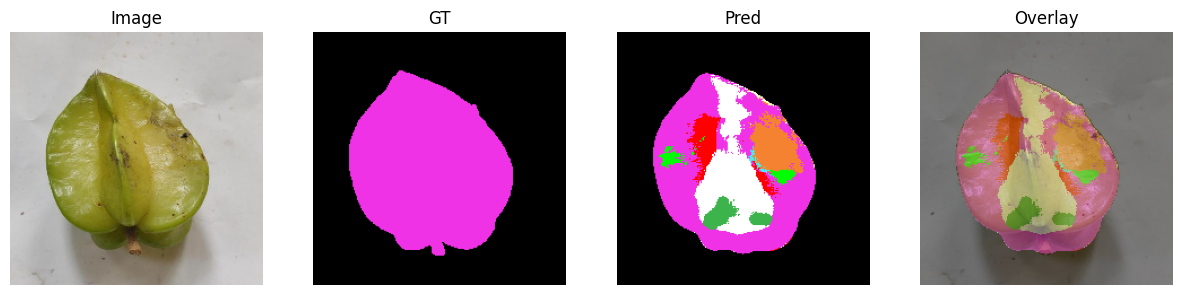

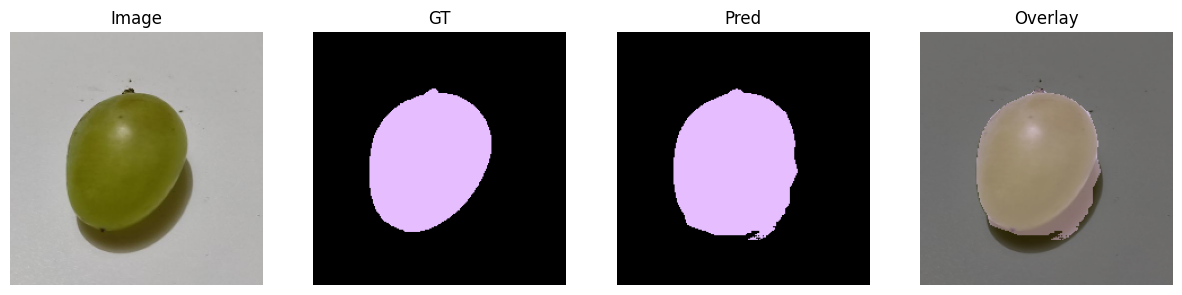

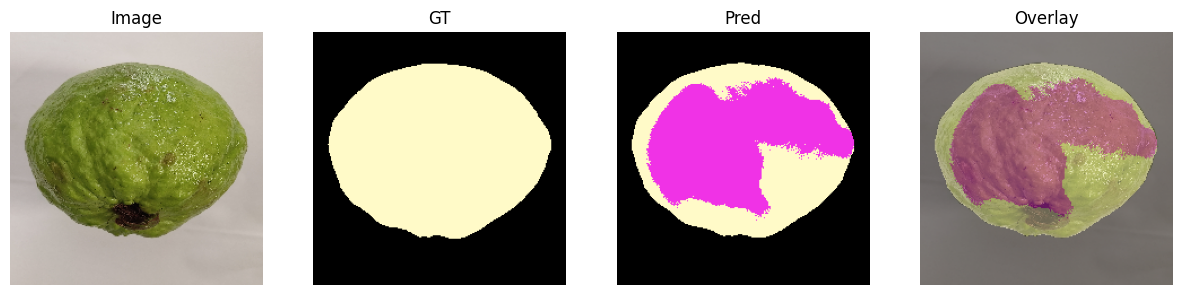

In [35]:
visualize(model, val_pairs, 3)


In [30]:
def extract_detected_fruits(mask, min_area_ratio=0.01):
    """
    mask: predicted class mask (H,W)
    min_area_ratio: minimum % of image area to count class
    """
    h, w = mask.shape
    total_pixels = h * w

    detected = []

    for c in np.unique(mask):
        if c == 0:
            continue

        area = np.sum(mask == c)
        ratio = area / total_pixels

        if ratio >= min_area_ratio:
            detected.append(reverse_class_map[c])

    return detected


In [31]:
def test_multi_fruit_image(image_path, model):
    """
    Test semantic segmentation on image containing multiple fruits
    """

    # -------- Read image --------
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError("Image not found!")

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    # -------- Preprocess --------
    img_resized = cv2.resize(img_rgb, IMG_SIZE)
    inp = img_resized.astype(np.float32) / 255.0
    inp = np.expand_dims(inp, axis=0)

    # -------- Predict --------
    pred = model.predict(inp, verbose=0)[0]
    pred_mask = np.argmax(pred, axis=-1)

    # -------- Resize mask back --------
    pred_mask = cv2.resize(
        pred_mask.astype(np.uint8),
        (w, h),
        interpolation=cv2.INTER_NEAREST
    )

    # -------- Color mask --------
    colored_mask = mask_to_color(pred_mask)

    # -------- Overlay --------
    overlay = cv2.addWeighted(
        img_rgb.astype(np.uint8), 0.6,
        colored_mask.astype(np.uint8), 0.4, 0
    )

    # -------- Detected classes --------
    detected_fruits = extract_detected_fruits(
    pred_mask,
    min_area_ratio=0.01   # 1% من الصورة
)

    return img_rgb, colored_mask, overlay, detected_fruits


Detected fruits: ['Apple_Gala', 'Banana', 'Carambola', 'Orange', 'Pineapple', 'Pomegranate']


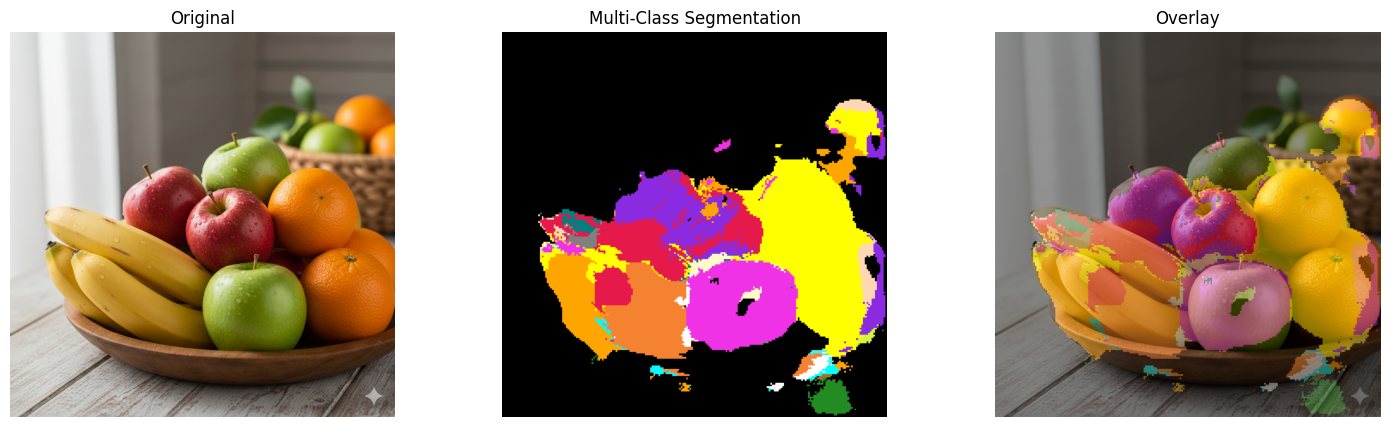

In [36]:
test_image = "/content/testf.png"  # صورة فيها أكتر من فاكهة

img, seg, overlay, fruits_found = test_multi_fruit_image(
    test_image, model
)

print("Detected fruits:", fruits_found)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.imshow(img); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(seg); plt.title("Multi-Class Segmentation"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay"); plt.axis("off")
plt.show()


In [33]:
def visualize_color_legend():
    fig, ax = plt.subplots(figsize=(8, num_classes * 0.4))

    for i in range(num_classes):
        color = COLOR_MAP[i] / 255.0
        fruit = reverse_class_map[i]

        ax.barh(i, 1, color=color)
        ax.text(1.05, i, f"{i}: {fruit}", va='center')

    ax.set_xlim(0, 2)
    ax.set_ylim(-1, num_classes)
    ax.axis("off")
    ax.set_title("Fruit Classes – Color Legend", fontsize=14)

    plt.show()


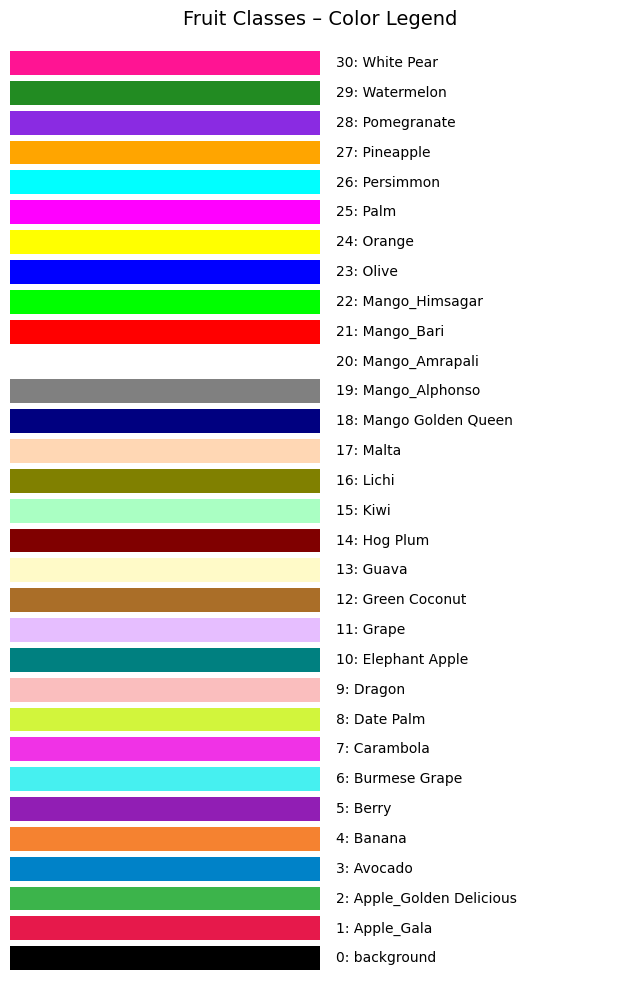

In [34]:
visualize_color_legend()
